In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Zanetti/')

In [0]:
# IPython objects
from IPython.display import display, Markdown

# Data analysis libraries
import numpy as np
np.random.seed(2020)
import pandas as pd
from scipy.stats import norm

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
hist_kwargs = {"edgecolor":"black"}

# others
from glob import glob
from tqdm import tqdm

# analysis functions
from Functions import *

data_path = "drive/My Drive/Colab Notebooks/Zanetti/data/"

## Physics

In [0]:
physics_file = data_path+"physics/RunMerged.txt"

In [0]:
def Open_File_Physics(data_file):
    with open(data_file) as f:
        tot_ev = len(list(f))

    # loop over events and perform analysis
    Ev_list = []
    selected_ev = 0
    with open(data_file) as f:
        with tqdm(total=tot_ev) as pbar:
            for line in f:
                # read event
                ev, evNum, hits = Read_Data(line)
                # filter by hit position
                ev_left, ev_right, hits_left, hits_right = Points_Filter(ev)
                # select event
                sel_left,  chambers_left,  n_layers_left  = Select_Events_Calibration(ev_left,  hits_left)
                sel_right, chambers_right, n_layers_right = Select_Events_Calibration(ev_right, hits_right)
                
                if sel_left and sel_right: selected_ev += 1

                # save most important information, in order to plot or reperform the analysis
                # without reading the whole file again
                Ev_list.append(
                    {
                        "Number"    : evNum,
                        "Dataframe" : ev,
                        "Hits"      : hits,
                        "Accepted"  : sel_left and sel_right,
                        "Chambers"  : chambers_left+chambers_right,
                        "Layers"    : [n_layers_left, n_layers_right]
                    }
                )

                pbar.update()
                
    print("{:35} = {:d}"    .format("Total number of events in the Run", tot_ev))
    print("{:35} = {:d}"    .format("Number of accepted events"        , selected_ev))
    print("{:35} = {:.4f} %".format("Fraction of accepted events"      , selected_ev/tot_ev*100))
    return Ev_list

In [0]:
def Physics(Ev_list):
    tot_ev = len(Ev_list)
    selected_ev = 0
    # number of hits selected events
    Ev_hits = {"left":[], "right":[]}
    # angular coefficient of fit
    Ev_slope = {"left":[], "right":[]}
    # residuals from good events fit
    Ev_residuals = {"left":[], "right":[]}
    
    print("Performing fit and analysis")
    with tqdm(total=tot_ev) as pbar:
        for event in Ev_list:
            if event["Accepted"]:
                ev = event["Dataframe"]
                layers = event["Layers"]
        
                # filter by hit position
                ev_left, ev_right, hits_left, hits_right = Points_Filter(ev)
                # save hit numbers
                Ev_hits["left"] .append(hits_left )
                Ev_hits["right"].append(hits_right)
                
                # save slope values
                gf_results_left  = Global_Fit_Physics(ev_left , layers[0])
                gf_results_right = Global_Fit_Physics(ev_right, layers[1])
                Ev_slope["left"] .append(gf_results_left ["slope"])
                Ev_slope["right"].append(gf_results_right["slope"])
                
                # save residuals
                Ev_residuals["left"]  += gf_results_left ["residuals"]
                Ev_residuals["right"] += gf_results_right["residuals"]
                
            pbar.update()
            
    print("#### Hit distribution (selected events)")
    
    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
    ax1.hist(Ev_hits["left"] , **hist_kwargs)
    ax1.set_title("Left Side")
    ax1.set_xlabel("Number of hits")
    ax2.hist(Ev_hits["right"], **hist_kwargs)
    ax2.set_title("Right Side")
    ax2.set_xlabel("Number of hits")
    plt.show()

    print("#### Slope distribution (selected events)")

    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
    Gaussian_Fit_Hist(ax1, Ev_slope["left"] , nbins=30, **hist_kwargs)
    ax1.set_title("Left Side")
    ax1.set_xlabel("Slope")
    Gaussian_Fit_Hist(ax2, Ev_slope["right"], nbins=30, **hist_kwargs)
    ax2.set_title("Right Side")
    ax2.set_xlabel("Slope")
    plt.show()

    print("#### Residuals")

    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
    Gaussian_Fit_Hist(ax1, Ev_residuals["left"] , nbins=30, hist_range=(-25,25), **hist_kwargs)
    ax1.set_title("Left Side")
    ax1.set_xlabel("Residuals [mm]")
    Gaussian_Fit_Hist(ax2, Ev_residuals["right"], nbins=30, hist_range=(-25,25), **hist_kwargs)
    ax2.set_title("Right Side")
    ax2.set_xlabel("Residuals [mm]")
    plt.show()
            
    return Ev_hits, Ev_slope, Ev_residuals

In [7]:
Ev_list = Open_File_Physics(physics_file)

100%|██████████| 422291/422291 [54:24<00:00, 129.38it/s]

Total number of events in the Run   = 422291
Number of accepted events           = 1305
Fraction of accepted events         = 0.3090 %


  0%|          | 893/422291 [00:00<01:23, 5025.27it/s]

Performing fit and analysis


100%|██████████| 422291/422291 [5:20:13<00:00, 21.98it/s]


#### Hit distribution (selected events)


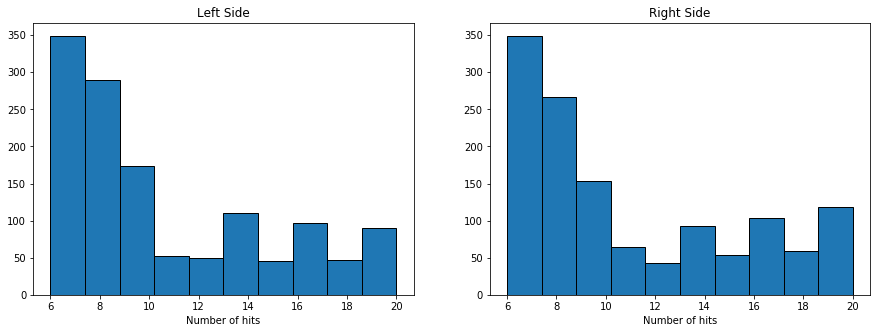

#### Slope distribution (selected events)


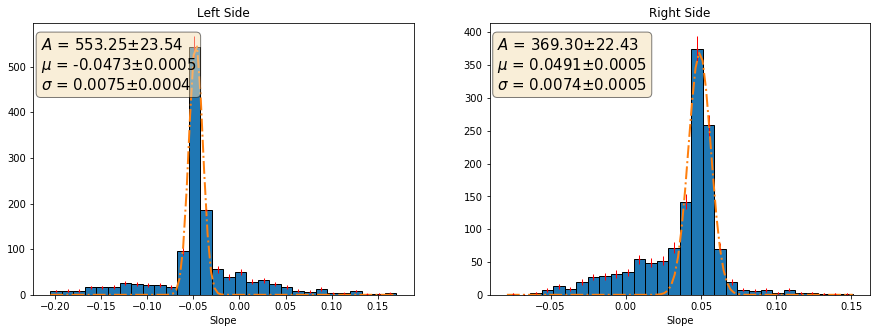

#### Residuals


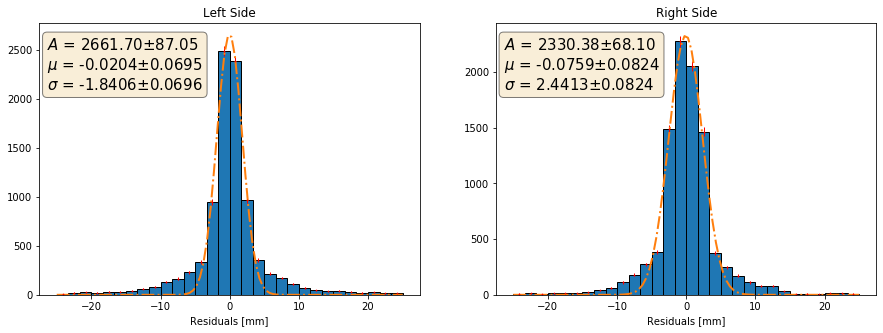

In [8]:
Ev_hits, Ev_slope, Ev_residuals = Physics(Ev_list)

892


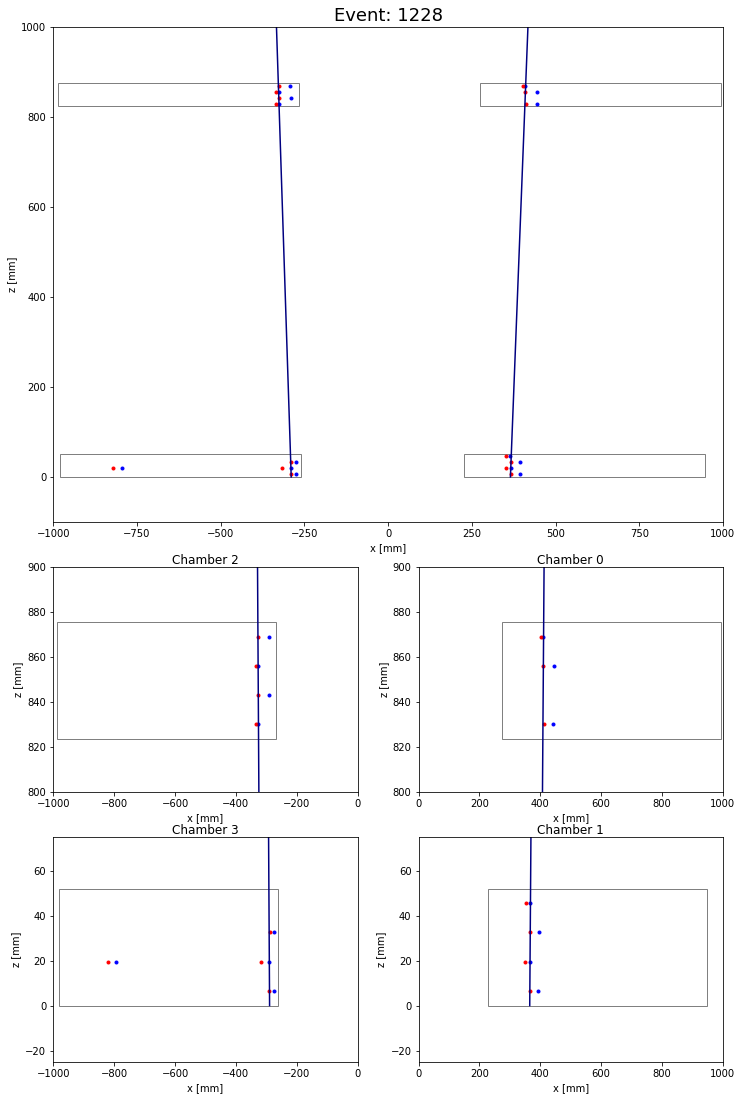

In [9]:
idx = 0
for i, ev in enumerate(Ev_list):
    if ev["Accepted"]: 
        idx = i
        break
print(idx)
Make_Plot(Ev_list[idx])

In [0]:
np.savetxt(data_path+"Ev_hist_left.txt" , Ev_hits["left"])
np.savetxt(data_path+"Ev_hist_right.txt", Ev_hits["right"])

In [0]:
np.savetxt(data_path+"Ev_slope_left.txt" , Ev_slope["left"])
np.savetxt(data_path+"Ev_slope_right.txt", Ev_slope["right"])

In [0]:
np.savetxt(data_path+"Ev_residuals_left.txt" , Ev_residuals["left"])
np.savetxt(data_path+"Ev_residuals_right.txt", Ev_residuals["right"])